# Week 5 - Generative Dog Images

For this week's mini-project, you will participate in one of the Kaggle competitions(Refer the NOTE below for detailed information on the expectations):

Generative Dog Images Dataset (Old) : https://www.kaggle.com/c/generative-dog-images

We will use this Kaggle competition to practice building and training generative deep learning models (mostly GAN). Kaggle introduces an evaluation metric called MiFID (Memorization-informed Fréchet Inception Distance) score to evaluate the quality of generated images. Please have a close look at their explanation here: https://www.kaggle.com/c/gan-getting-started/overview/evaluation

A mini-project is a weekly assignment, so we don't expect you to iterate over your project until you have a model capable of winning the challenge. The learner needs to show a score that reasonably reflects that they completed the rubric parts of this project, E.g., the score shouldn't be higher than 1000.

# Brief Description of the Problem
```
"You might not think that programmers are artists, but programming is an extremely creative profession. It’s logic-based creativity."
- John Romero
```

A generative adversarial network (GAN) is a class of machine learning system invented by Ian Goodfellow in 2014. Two neural networks compete with each other in a game. Given a training set, this technique learns to generate new data with the same statistics as the training set.

I’ll be training generative models to create images of dogs. Only this time, there’s no ground truth data for you to predict. 

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Dog? That’s the challenge I’ll take on!

**The Challenge:** <br/>
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our project,I will generate images in the style of Dog. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates handful of Dog-style images.

# The Dataset:

The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. Images are color format rgb 64 x 64. <br/>

Contents of this dataset: <br/>
Number of categories: 120<br/>
Number of images: 22,126<br/>
Annotations: Class labels, Bounding boxes<br/>

Below I show sample of 25 images.<br/>
array shape (1000, 64, 64, 3)

In [1]:
# Standard library
import os
import time
import random
import io
import zipfile
import xml.etree.ElementTree as ET
from glob import glob
from io import BytesIO
from pathlib import Path

# Data handling & plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Reshape, Flatten,
    concatenate, UpSampling2D
)
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K

# Configure mixed precision and clear any previous session
mixed_precision.set_global_policy('mixed_float16')
K.clear_session()

2025-05-22 07:08:00.906096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747897681.154221      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747897681.219514      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loaded 1000 images → array shape (1000, 64, 64, 3)


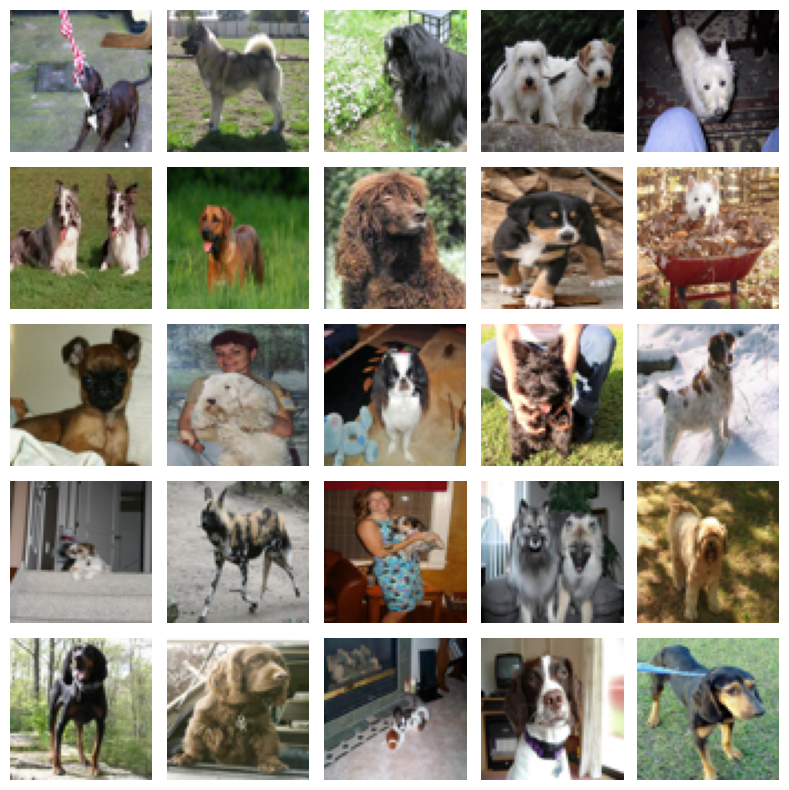

In [3]:
# Load images from the - Generative Dog Image Repository

ZIP_PATH   = '/kaggle/input/generative-dog-images/all-dogs.zip'
MAX_IMAGES = 1_000         
SIZE       = (64, 64)       
GRID_SIDE  = 5        

def load_images(zip_path: str, size=(64, 64), max_images=None):
    """Return an array of images scaled to [-1, 1] float32."""
    with zipfile.ZipFile(zip_path) as zf:
        names = [n for n in zf.namelist()                             
                 if n.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if max_images:  
            names = names[:max_images]

        imgs = []
        for name in names:
            with zf.open(name) as f:
                img = (Image.open(f)
                            .convert('RGB')
                            .resize(size))
                imgs.append(np.asarray(img, dtype=np.float32) / 127.5 - 1.0)

    return np.stack(imgs, axis=0)

images = load_images(ZIP_PATH, SIZE, MAX_IMAGES)
print(f'Loaded {images.shape[0]} images → array shape {images.shape}')

sel = random.sample(range(images.shape[0]), GRID_SIDE**2)
plt.figure(figsize=(8, 8))
for i, idx in enumerate(sel, 1):
    plt.subplot(GRID_SIDE, GRID_SIDE, i)
    plt.imshow((images[idx] + 1) / 2)      # back to [0, 1] for display
    plt.axis('off')
plt.tight_layout()
plt.show()


# Exploratory data analysis (EDA)

The dataset we are working with consists of 22,126 annotated images of dogs, each record containing both metadata (folder/filename, image width, height, depth) and annotation fields (breed name, pose, truncated/difficult flags, and bounding‐box coordinates). <br/>

Please review the bar chart "Top FileCounts per Name".  Of these classes, the twenty most frequently represented breeds range from roughly 290 examples for the top-ranked Afghan_hound down to about 210 for the twentieth-ranked Tibetan_terrier. <br/>

In the "Distribution of Image Heights" and "Distribution of Image widiths", the image-size histograms reveal that the vast majority of pictures fall within a mid-range of 300–500 pixels in height and 300–600 pixels in width, with very few images smaller than ~200 pixels or exceeding ~800 pixels in either dimension.<br/>

In [2]:
# Load Data For Exploratory Data Analysis
zip_path = '/kaggle/input/generative-dog-images/Annotation.zip'

def load_images_from_zip_to_dataset(zip_path, img_size):
    image_list = []

    with zipfile.ZipFile(zip_path, 'r') as archive:
        # file_list = [f for f in archive.namelist() if (not 'MACOSX' in f and 'Afghan_hound' in f )]
        file_list = [f for f in archive.namelist() if ('Afghan_hound' in f )]

    return file_list

def parse_annotation_xml(xml_content):
    root = ET.fromstring(xml_content)

    folder = root.findtext("folder")
    filename = root.findtext("filename")
    width = root.find("size/width").text
    height = root.find("size/height").text
    depth = root.find("size/depth").text

    data = []

    for obj in root.findall("object"):
        name = obj.findtext("name")
        pose = obj.findtext("pose")
        truncated = obj.findtext("truncated")
        difficult = obj.findtext("difficult")
        bndbox = obj.find("bndbox")
        xmin = bndbox.findtext("xmin")
        ymin = bndbox.findtext("ymin")
        xmax = bndbox.findtext("xmax")
        ymax = bndbox.findtext("ymax")

        data.append({
            "folder": folder,
            "filename": filename,
            "width": int(width),
            "height": int(height),
            "depth": int(depth),
            "name": name,
            "pose": pose,
            "truncated": int(truncated),
            "difficult": int(difficult),
            "xmin": int(xmin),
            "ymin": int(ymin),
            "xmax": int(xmax),
            "ymax": int(ymax)
        })

    return data

def load_annotations_from_zip(zip_path):
    annotations = []

    with zipfile.ZipFile(zip_path, 'r') as archive:
        xml_files = [f for f in archive.namelist() if not '__MACOSX' in f]
        for xml_file in xml_files:
            with archive.open(xml_file) as file:
                xml_bytes = file.read()
                if not xml_bytes.strip():
                    continue
                try:
                    annotation_data = parse_annotation_xml(xml_bytes.decode('utf-8'))
                    annotations.extend(annotation_data)
                except ET.ParseError:
                    print(f"Skipping malformed XML file: {xml_file}")

    df = pd.DataFrame(annotations)
    return df

zip_path = "/kaggle/input/generative-dog-images/Annotation.zip"
df = load_annotations_from_zip(zip_path)

print(df.info())
df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22126 entries, 0 to 22125
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   folder     22126 non-null  object
 1   filename   22126 non-null  object
 2   width      22126 non-null  int64 
 3   height     22126 non-null  int64 
 4   depth      22126 non-null  int64 
 5   name       22126 non-null  object
 6   pose       22126 non-null  object
 7   truncated  22126 non-null  int64 
 8   difficult  22126 non-null  int64 
 9   xmin       22126 non-null  int64 
 10  ymin       22126 non-null  int64 
 11  xmax       22126 non-null  int64 
 12  ymax       22126 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 2.2+ MB
None


,folder,filename,width,height,depth,name,pose,truncated,difficult,xmin,ymin,xmax,ymax
0,02097658,n02097658_98,500,400,3,silky_terrier,Unspecified,0,0,93,117,269,289
1,02097658,n02097658_98,500,400,3,silky_terrier,Unspecified,0,0,290,104,393,244
2,02097658,n02097658_2535,500,333,3,silky_terrier,Unspecified,0,0,216,69,498,289
3,02097658,n02097658_271,500,332,3,silky_terrier,Unspecified,0,0,0,0,366,331
4,02097658,n02097658_427,1024,768,3,silky_terrier,Unspecified,0,0,174,1,1018,762
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22121,02089078,n02089078_2227,200,179,3,black-and-tan_coonhound,Unspecified,0,0,7,10,176,166
22122,02089078,n02089078_2478,640,480,3,black-and-tan_coonhound,Unspecified,0,0,124,52,590,400
22123,02089078,n02089078_3532,240,180,3,black-and-tan_coonhound,Unspecified,0,0,0,22,123,179
22124,02089078,n02089078_3355,230,254,3,black-and-tan_coonhound,Unspecified,0,0,0,10,229,245


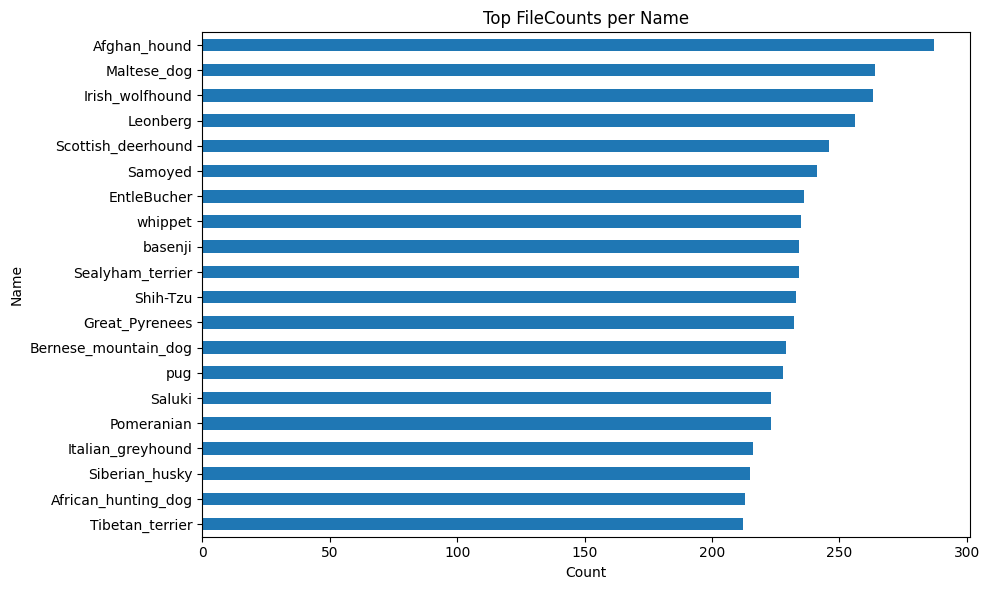

In [4]:
df['name'].value_counts().head(20).sort_values().plot(kind='barh', figsize=(10, 6))
#plt.title('Top 10 Dog Breeds
plt.title('Top FileCounts per Name')
plt.xlabel('Count')
plt.ylabel('Name')
plt.tight_layout()
plt.show()

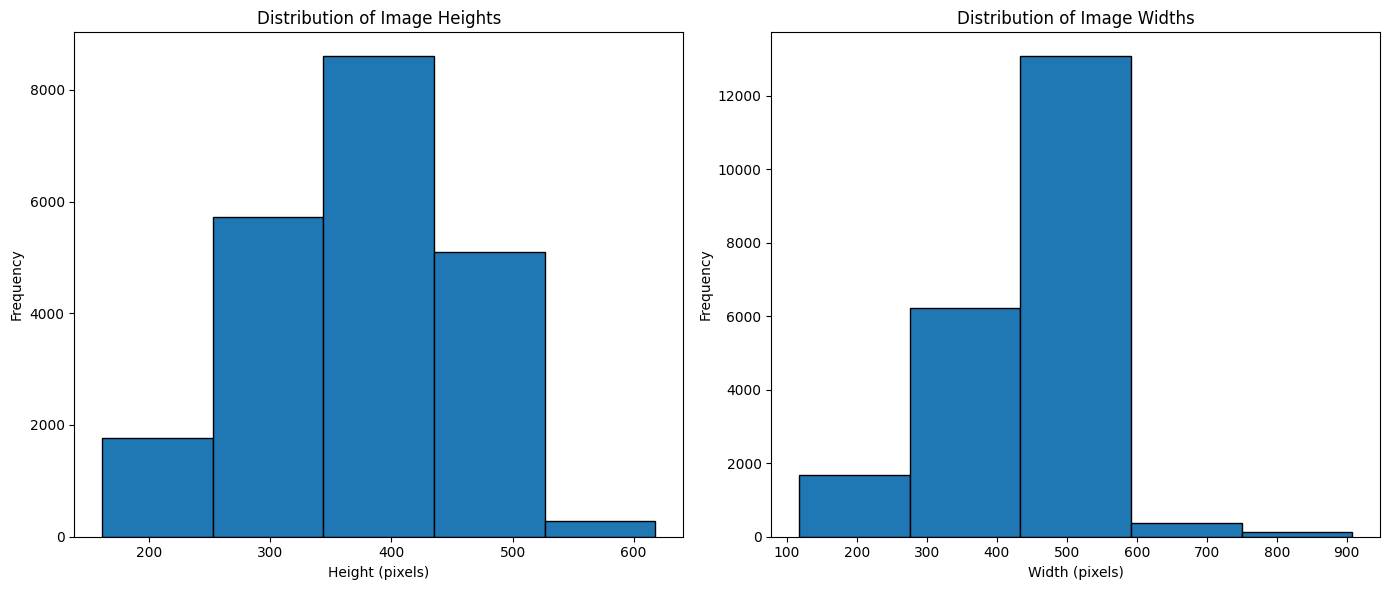

In [5]:
# Filter out height outliers
Q1 = df['height'].quantile(0.25)
Q3 = df['height'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df['height'] >= lower_bound) & (df['height'] <= upper_bound)]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# histogram
axes[0].hist(df_filtered['height'], bins=5, edgecolor='black')
axes[0].set_title('Distribution of Image Heights')
axes[0].set_xlabel('Height (pixels)')
axes[0].set_ylabel('Frequency')
axes[1].hist(df_filtered['width'], bins=5, edgecolor='black')
axes[1].set_title('Distribution of Image Widths')
axes[1].set_xlabel('Width (pixels)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Model Architecture (model building and training)

Analysis (model building and training) Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.

In the GAN model, the generator begins by taking a 100-dimensional noise vector and passing it through a fully connected layer (no bias) to produce an 8×8×512 tensor, which is immediately batch-normalized and activated with LeakyReLU. It then applies four Conv2DTranspose blocks—each with a 5×5 kernel, stride 2, “same” padding, no bias, batch normalization, and LeakyReLU—to successively upsample the feature map from 8×8 to 128×128, halving the channel count at each stage (512→256→128→64). A final Conv2DTranspose layer with a 5×5 kernel, stride 2, “same” padding, and tanh activation produces the 128×128×3 output image, with pixel values in \[–1, 1].

The discriminator mirrors this in reverse: it ingests a 128×128×3 image and applies four Conv2D layers (5×5 kernels, stride 2, “same” padding) with LeakyReLU activations and progressively increasing dropout rates (0.3→0.4→0.5→0.5) as depth grows (64→128→256→512 channels). Finally, it flattens the activations and uses a single dense neuron to output a pre-activation (logit) indicating real vs. fake.

In [2]:
# Constants
zip_path = '/kaggle/input/generative-dog-images/all-dogs.zip'
IMG_SIZE = 128
BATCH_SIZE = 32

def image_generator(zip_path, img_size):
    with zipfile.ZipFile(zip_path, 'r') as archive:
        file_list = [f for f in archive.namelist() if f.endswith(('.jpg', '.jpeg', '.png'))]

        for file in file_list:
            try:
                with archive.open(file) as image_file:
                    img = Image.open(BytesIO(image_file.read())).convert('RGB')
                    img = img.resize((img_size, img_size))
                    img = np.asarray(img) / 127.5 - 1.0  # Normalize to [-1, 1]
                    yield img.astype(np.float32)
            except:
                continue

# Create streaming dataset from generator
def load_dataset_streamed(zip_path, img_size):
    output_signature = tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32)
    dataset = tf.data.Dataset.from_generator(
        lambda: image_generator(zip_path, img_size),
        output_signature=output_signature
    )
    return dataset.shuffle(20000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Load streamed dataset
train_dataset = load_dataset_streamed(zip_path, IMG_SIZE)

# Inspect
for batch in train_dataset.take(1):
    print('Batch shape:', batch.shape)


I0000 00:00:1747897710.580787      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747897710.581478      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Exception ignored in: <generator object image_generator at 0x7d2c000b4760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/dataset_ops.py", line 872, in iterator_completed
    del self._iterators[self._normalize_id(iterator_id)]
        ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: generator ignored GeneratorExit


Batch shape: (32, 128, 128, 3)


In [3]:
# Define the Generator Model (AutoEncoder)
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 512)),

        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Define the Discriminator Model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMG_SIZE, IMG_SIZE, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),  # shallow layer → lighter dropout

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.4),  # slightly more regularization

        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.5),  # deep layers → even stronger dropout

        layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32768)               │       3,276,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 256)         │       3,276,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 3)         │           4,800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,715,264 (29.43 MB)

 Trainable params: 7,648,832 (29.18 MB)

 Non-trainable params: 66,432 (259.50 KB)

In [6]:
discriminator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_20 (LeakyReLU)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_21 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_22 (LeakyReLU)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 512)           │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_23 (LeakyReLU)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,339,329 (16.55 MB)

 Trainable params: 4,339,329 (16.55 MB)

 Non-trainable params: 0 (0.00 B)

# Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In regards of the GAN Training Loss over Epochs Graph; The generator loss jumps from around 1.2 at start to a peak of ~2.55 around epoch 8–9, then gradually falls to ~2.05 by epoch 24. Meanwhile, the discriminator loss steadily drops from ~1.21 to ~0.70 by epoch 10 before rising slightly to ~0.87 by epoch 24.  This illustrates  the adversarial “tug-of-war” typical of GAN training.

Epoch Training shows improved learning and improved dog image generation. Although with there is clearly room for improvement.  The GAN used DCGAN to generate face images. In addition, I trained our model using a standard DCGAN implementation.

In [4]:
# Define Loss Functions & Optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [8]:
# Define Training Functions
# DCGAN Implementation

EPOCHS = 25
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Foward Pass
        generated_images = generator(noise, training=True) 
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Compute Losses
        gen_loss = generator_loss(fake_output) 
        disc_loss = discriminator_loss(real_output, fake_output) 

    # Backpropagation & Optimization
    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

In [11]:
# Visualize and Save Generated Images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] * 0.5 + 0.5))  # scale [-1,1] → [0,1]
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

In [12]:
# Train the Model (with loss tracking)

def train(dataset, epochs, start_epoch=0):
    # Start time
    start_time = time.time()
    
    gen_loss_history = []
    disc_loss_history = []

    for epoch in range(start_epoch, start_epoch + epochs):
        print(f"Epoch {epoch+1}/{start_epoch + epochs}")
        gen_loss_epoch = []
        disc_loss_epoch = []

        for image_batch in dataset:
            noise = tf.random.normal([BATCH_SIZE, noise_dim])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = generator(noise, training=True)
                real_output = discriminator(image_batch, training=True)
                fake_output = discriminator(generated_images, training=True)

                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

            gen_loss_epoch.append(gen_loss.numpy())
            disc_loss_epoch.append(disc_loss.numpy())

        # Track average losses
        mean_gen = np.mean(gen_loss_epoch)
        mean_disc = np.mean(disc_loss_epoch)
        gen_loss_history.append(mean_gen)
        disc_loss_history.append(mean_disc)

        # Calculate elapsed time
        elapsed = int(time.time() - start_time)
        hours, rem = divmod(elapsed, 3600)
        minutes, seconds = divmod(rem, 60)

        # Print formatted output
        print(f"[{hours:02d}h:{minutes:02d}m:{seconds:02d}s] Epoch {epoch} - Generator loss: {mean_gen:.4f}, Discriminator loss: {mean_disc:.4f}")
        # print(f"Generator loss: {mean_gen:.4f}, Discriminator loss: {mean_disc:.4f}")

        # Visualize progress
        is_final_epoch = (epoch + 1 == start_epoch + epochs)
        if (epoch %5 == 0) or is_final_epoch:
            generate_and_save_images(generator, epoch + 1, seed)

            # Save generator
            generator.save('best_generator_model.h5')

            # gen_hist, disc_hist = gen_loss_history, disc_loss_history

            # Plot
            # plt.figure(figsize=(10,5))
            # plt.plot(gen_hist, label="Generator Loss")
            # plt.plot(disc_hist, label="Discriminator Loss")
            # plt.title("GAN Training Loss Over Epochs")
            # plt.xlabel("Epoch")
            # plt.ylabel("Loss")
            # plt.legend()
            # plt.grid(True)
            # plt.show()

    return gen_loss_history, disc_loss_history


Epoch 1/25


I0000 00:00:1747897977.723498      35 cuda_dnn.cc:529] Loaded cuDNN version 90300


[00h:05m:42s] Epoch 0 - Generator loss: 1.1927, Discriminator loss: 1.2100


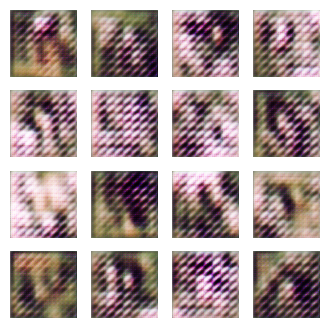

Epoch 2/25
[00h:11m:20s] Epoch 1 - Generator loss: 1.1715, Discriminator loss: 1.1786
Epoch 3/25
[00h:16m:58s] Epoch 2 - Generator loss: 1.6543, Discriminator loss: 0.9951
Epoch 4/25
[00h:22m:37s] Epoch 3 - Generator loss: 1.7527, Discriminator loss: 0.9494
Epoch 5/25
[00h:28m:13s] Epoch 4 - Generator loss: 1.9552, Discriminator loss: 0.8794
Epoch 6/25
[00h:33m:48s] Epoch 5 - Generator loss: 2.1944, Discriminator loss: 0.8127


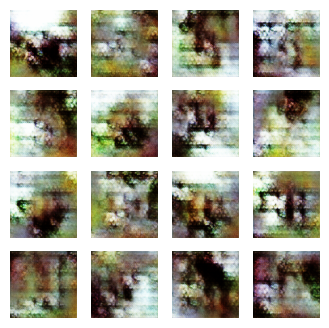

Epoch 7/25
[00h:39m:27s] Epoch 6 - Generator loss: 2.2544, Discriminator loss: 0.7996
Epoch 8/25
[00h:45m:02s] Epoch 7 - Generator loss: 2.2781, Discriminator loss: 0.7851
Epoch 9/25
[00h:50m:34s] Epoch 8 - Generator loss: 2.3555, Discriminator loss: 0.7508
Epoch 10/25
[00h:56m:08s] Epoch 9 - Generator loss: 2.4726, Discriminator loss: 0.7250
Epoch 11/25
[01h:01m:43s] Epoch 10 - Generator loss: 2.5254, Discriminator loss: 0.7087


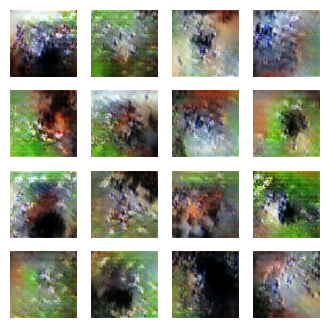

Epoch 12/25
[01h:07m:18s] Epoch 11 - Generator loss: 2.5454, Discriminator loss: 0.7109
Epoch 13/25
[01h:12m:53s] Epoch 12 - Generator loss: 2.5048, Discriminator loss: 0.7228
Epoch 14/25
[01h:18m:32s] Epoch 13 - Generator loss: 2.5394, Discriminator loss: 0.7239
Epoch 15/25
[01h:24m:09s] Epoch 14 - Generator loss: 2.4113, Discriminator loss: 0.7563
Epoch 16/25
[01h:29m:45s] Epoch 15 - Generator loss: 2.4647, Discriminator loss: 0.7408


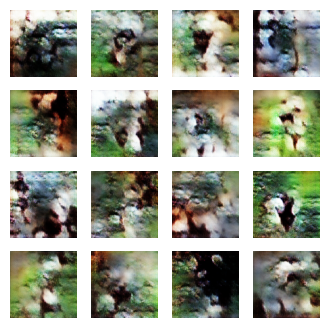

Epoch 17/25
[01h:35m:21s] Epoch 16 - Generator loss: 2.3847, Discriminator loss: 0.7541
Epoch 18/25
[01h:40m:55s] Epoch 17 - Generator loss: 2.3281, Discriminator loss: 0.7820
Epoch 19/25
[01h:46m:31s] Epoch 18 - Generator loss: 2.1913, Discriminator loss: 0.8101
Epoch 20/25
[01h:52m:04s] Epoch 19 - Generator loss: 2.0942, Discriminator loss: 0.8226
Epoch 21/25
[01h:57m:40s] Epoch 20 - Generator loss: 2.0759, Discriminator loss: 0.8406


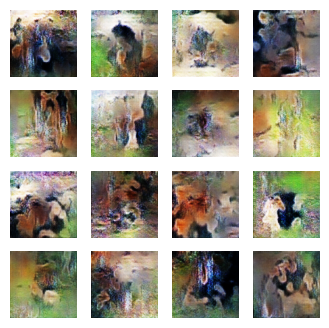

Epoch 22/25
[02h:03m:15s] Epoch 21 - Generator loss: 2.0443, Discriminator loss: 0.8480
Epoch 23/25
[02h:08m:50s] Epoch 22 - Generator loss: 2.0112, Discriminator loss: 0.8538
Epoch 24/25
[02h:14m:24s] Epoch 23 - Generator loss: 2.0521, Discriminator loss: 0.8414
Epoch 25/25
[02h:19m:59s] Epoch 24 - Generator loss: 2.0559, Discriminator loss: 0.8631


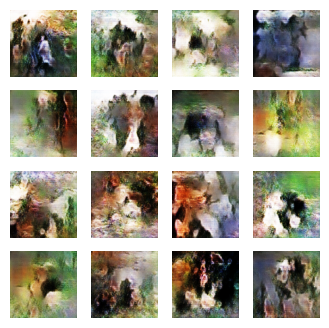

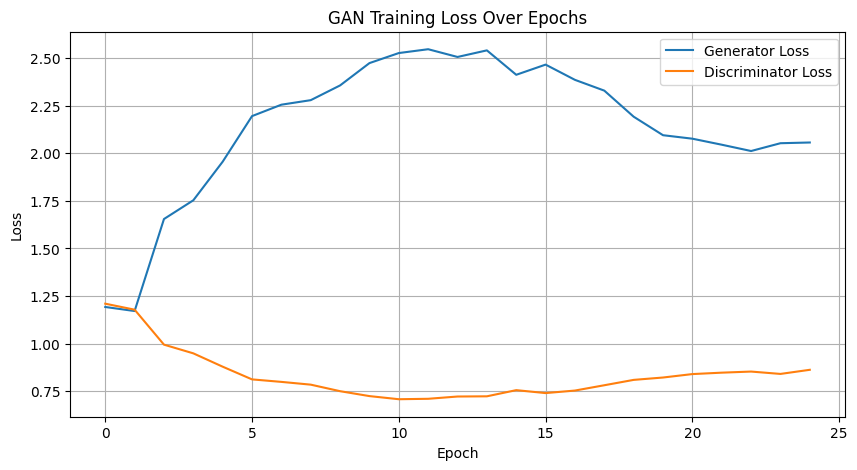

In [14]:
gen_hist, disc_hist = train(train_dataset, epochs=EPOCHS)

# Plot
plt.figure(figsize=(10,5))
plt.plot(gen_hist, label="Generator Loss")
plt.plot(disc_hist, label="Discriminator Loss")
plt.title("GAN Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Discussion/Conclusion

Although our model has started to learn and produce some structure, I believe it still fails to generate a truly convincing dog images. To improve, we could possibly train for more epochs, adjust the network’s architecture, or incorporate transfer learning—particularly by initializing the generator with pre-trained weights so it isn’t learning from scratch. Extending the training time would likely help as well. 
<br/><br/>
The samples show that we’re only just beginning to capture dog-like colors and rough shapes. 
These GANs are complicated, tricky and intricate; they  demand considerable experimentation and fine-tuning. This project merely scratches the surface of their potential.

# References:

Monet CycleGAN Tutorial <br/>
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

I’m Something of a Painter Myself (FID) <br/>
https://www.kaggle.com/competitions/gan-getting-started/overview

Improved Techniques for Training GANs <br/>
https://arxiv.org/pdf/1606.03498

Stanford Dogs Dataset <br/>
http://vision.stanford.edu/aditya86/ImageNetDogs/

DCGAN to generate face images <br/>
https://keras.io/examples/generative/dcgan_overriding_train_step/
